In [11]:
from transformers import BeitImageProcessor, BeitForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import json

In [2]:
processor = BeitImageProcessor.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k-ft22k')

In [3]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 21,841 ImageNet-22k classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: tabby, tabby_cat


In [1]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on COCO panoptic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_panoptic_map = result["segmentation"]

/home/yangwenhao/anaconda3/envs/lighting/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`label_ids_to_fuse` unset. No instance will be fused.


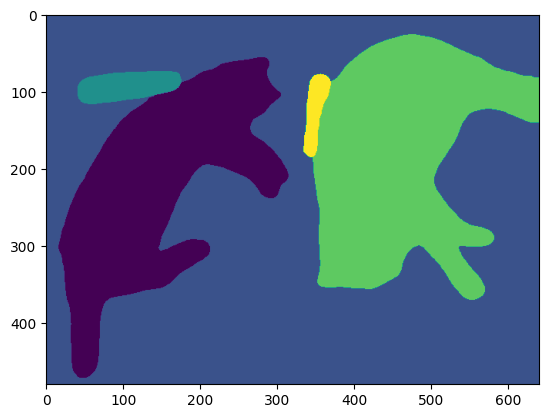

In [5]:
plt.imshow(predicted_panoptic_map)

In [6]:
result

{'segmentation': tensor([[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32),
 'segments_info': [{'id': 1,
   'label_id': 15,
   'was_fused': False,
   'score': 0.981745},
  {'id': 2, 'label_id': 57, 'was_fused': False, 'score': 0.978469},
  {'id': 3, 'label_id': 65, 'was_fused': False, 'score': 0.997983},
  {'id': 4, 'label_id': 15, 'was_fused': False, 'score': 0.978765},
  {'id': 5, 'label_id': 65, 'was_fused': False, 'score': 0.991965}]}

In [13]:
with open('/home/yangwenhao/.cache/huggingface/hub/models--facebook--mask2former-swin-large-coco-panoptic/snapshots/85b535928a783691eaf27467a573b26d543336ea/config.json', 'r') as f:
    configs = json.load(f)
    
configs['id2label']

In [18]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print(image)
inputs = processor(images=image, return_tensors="pt")

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7F7C9F57FF40>


In [22]:
img_path = "/home/work2020/yangwenhao/project/weibo_filter/data/Tourist_Attraction/005A0r1mly1g3f6tdbflvj30u0140102.jpg"
image = Image.open(img_path)
print(image.convert("RGB"))
inputs = processor(images=image.convert("RGB"), return_tensors="pt")
print(inputs)

<PIL.Image.Image image mode=RGB size=132x132 at 0x7F7C9ED4E8E0>
{'pixel_values': tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 1.9749, 2.1975, 2.2147],
          [2.2489, 2.2489, 2.2489,  ..., 2.1804, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.1975, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.0959, 2.3761, 2.3761],
          [2.4286, 2.4286, 2.4286,  ..., 2.3585, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.3761, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 

In [23]:
img_path = "/home/work2020/yangwenhao/project/weibo_filter/data/Tourist_Attraction/005A0r1mly1g3f6tdbflvj30u0140102.jpg"
image = Image.open(img_path)
inputs = processor(images=image.convert("RGB"), return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)
predicted_panoptic_map = result["segmentation"]

`label_ids_to_fuse` unset. No instance will be fused.


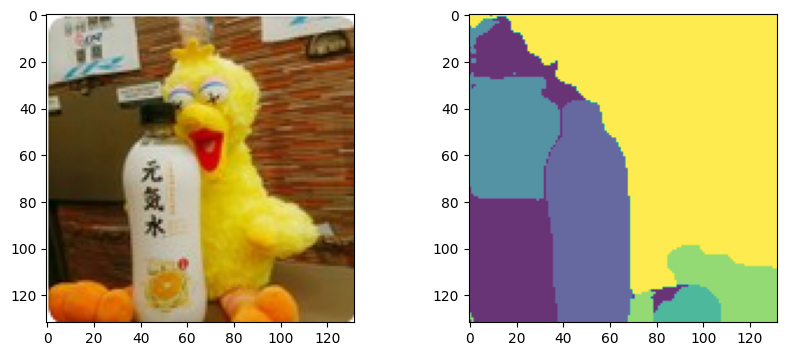

In [30]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
plt.imshow(predicted_panoptic_map, alpha=0.8)

In [39]:
for i in result['segments_info']:
    print("label: {:>20s}, \tscore: {:>6.4f}".format(configs['id2label'][str(i['label_id'])], i['score']))

label:               bottle, 	score: 0.9901
label:    wall-other-merged, 	score: 0.7937
label:               orange, 	score: 0.9058
label:         table-merged, 	score: 0.8599
label:           wall-brick, 	score: 0.9635


{'0': 'person',
 '1': 'bicycle',
 '2': 'car',
 '3': 'motorcycle',
 '4': 'airplane',
 '5': 'bus',
 '6': 'train',
 '7': 'truck',
 '8': 'boat',
 '9': 'traffic light',
 '10': 'fire hydrant',
 '11': 'stop sign',
 '12': 'parking meter',
 '13': 'bench',
 '14': 'bird',
 '15': 'cat',
 '16': 'dog',
 '17': 'horse',
 '18': 'sheep',
 '19': 'cow',
 '20': 'elephant',
 '21': 'bear',
 '22': 'zebra',
 '23': 'giraffe',
 '24': 'backpack',
 '25': 'umbrella',
 '26': 'handbag',
 '27': 'tie',
 '28': 'suitcase',
 '29': 'frisbee',
 '30': 'skis',
 '31': 'snowboard',
 '32': 'sports ball',
 '33': 'kite',
 '34': 'baseball bat',
 '35': 'baseball glove',
 '36': 'skateboard',
 '37': 'surfboard',
 '38': 'tennis racket',
 '39': 'bottle',
 '40': 'wine glass',
 '41': 'cup',
 '42': 'fork',
 '43': 'knife',
 '44': 'spoon',
 '45': 'bowl',
 '46': 'banana',
 '47': 'apple',
 '48': 'sandwich',
 '49': 'orange',
 '50': 'broccoli',
 '51': 'carrot',
 '52': 'hot dog',
 '53': 'pizza',
 '54': 'donut',
 '55': 'cake',
 '56': 'chair',
 '57